In [81]:
#import needed libraries.

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re

#list of colors that would be used for clusters later
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

In [82]:
#loading the dataset using pandas

df = pd.read_csv('taxi_data.csv')
# view the first five rows of the dataset
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [83]:
#check if any location is duplicate, subset on just the 'LON' and 'LAT' columns, the 'NAME' column could be duplicated.
df.duplicated(subset=['LON','LAT']).values.any()

True

In [84]:
#checking if there are missing values
df.isna().values.any()

True

In [85]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
#for this dataset a missing 'LON', 'LAT' rows won't be relevant so I am dropping them.
df.dropna(inplace=True)

#duplicate locations also needs cleean up, so I am keeping only the first row of any duplicated location
df.drop_duplicates(subset=['LON','LAT'], keep='first', inplace=True)

print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [86]:
# converting the dataframe to a numpy array
X = np.array(df[['LON', 'LAT']], dtype='float64')

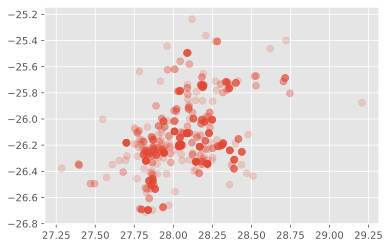

In [87]:
# plotting a scatter plot of the array
plt.scatter(X[:,0],X[:,1], alpha= 0.2, s=50)

In [88]:
# drawing a map that uses the start at the center of the points using folium.
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_starts=9, tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius = 5,
        popup = re.sub(r'[^a-zA-Z ]+', '', row.NAME),
        color = '#1787FE',
        fill = True,
        fill_color='#1787FE'
    ).add_to(m)

In [89]:
m

# KMeans Clustering

In [90]:
X = np.array(df[['LON','LAT']])
# k was choosen at random.
k = 70
model = KMeans(n_clusters=k, random_state=17)
model.fit(X)
class_predictions = model.predict(X)
# adding the prediction as a column
df['CLUSTER_kmeans{k}'] = class_predictions

In [91]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans{k}
0  28.17858 -25.73882         11th Street Taxi Rank                 15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                 15
2  27.83239 -26.53722          Adams Road Taxi Rank                  5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                 33
4  28.10144 -26.10567      Alexandra Main Taxi Rank                 18

In [92]:
# creating a function that create a map
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        cluster_colour = cols[row[cluster_column]]
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else: 
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
    return m

m = create_map(df, 'CLUSTER_kmeans{k}')    
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6367300948588169


In [93]:
m

In [94]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [00:25<00:00,  3.89it/s]

K=98
Silhouette Score: 0.6971995093259049


# DBSCAN 

In [95]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new = np.array([(counter+2)*x if x == -1 else x for counter, x in enumerate(dummy)])

In [96]:
new

array([-2, -3, -4,  2,  3,  4,  5, -9])

In [97]:
model = DBSCAN(eps=0.01, min_samples=5)
model.fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [98]:
m = create_map(df, 'CLUSTERS_DBSCAN')



print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138245464832
Silhouette outliers as singletons: 0.5667489347788776


In [99]:
m

# HDBSCAN


In [100]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.01)
class_predictions = model.fit_predict(X)
df['CLUSTER_HDBSCAN'] = class_predictions

In [101]:
m = create_map(df, 'CLUSTER_HDBSCAN')


print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504353546712
Silhouette outliers as singletons: 0.6389924830256725


# Addressing Outliers

In [102]:
# using K Nearest Neighbour
classifier = KNeighborsClassifier(n_neighbors=2)

In [103]:
df_train =df[df['CLUSTER_HDBSCAN'] != -1]
df_predict = df[df['CLUSTER_HDBSCAN'] == -1]


In [104]:
X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [105]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [106]:
predictions = classifier.predict(X_predict)

In [107]:
predictions

array([26, 41, 13, 44, 38, 26, 34,  4, 60, 60, 16, 16, 61, 24, 51, 51, 51,
       58, 41, 63, 13, 45, 15, 45, 45,  6,  0, 17, 26, 26, 26, 49, 49, 53,
       49, 13, 61, 26, 26, 39, 65, 31, 31, 31,  0, 46, 46, 21, 21, 60,  6,
        5, 24,  1, 63, 34, 64, 36, 36, 16,  7,  3, 63, 41, 13, 39, 39, 39,
       41, 40, 40, 25, 59, 57, 53, 53, 61, 26, 15, 15, 59, 63,  6, 19, 61,
       53, 48,  4, 41, 21, 64, 64, 64, 61, 61, 21, 23, 38, 31, 41, 55, 55])

In [108]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']

In [109]:
df.loc[df['CLUSTER_HDBSCAN']==-1, 'CLUSTER_hybrid'] = predictions

In [110]:
m = create_map(df, 'CLUSTER_hybrid')

In [111]:
m

In [112]:
class_predictions = df.CLUSTER_hybrid

print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')


Number of clusters found: 66
Silhouette: 0.5797532096602732


Text(0.5, 0, 'Cluster Size')

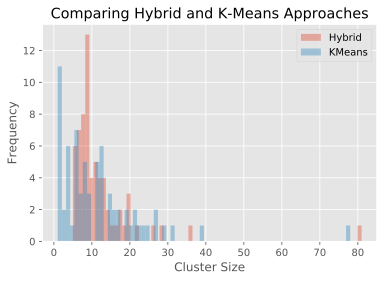

In [113]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, label='Hybrid')
df['CLUSTER_kmeans{k}'].value_counts().plot.hist(bins=70, alpha=0.4, label='KMeans')

plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')
plt.xlabel('Cluster Size')